# Segmentation


In [3]:
# Import training csv

import pandas as pd
df = pd.read_csv('../input/train.csv')
df.head(1)

,ID,Label
0,5c27f04c-bb99-11e8-b2b9-ac1f6b6435d0,8|5|0


In [4]:
# Load previously segmented image
from PIL import Image
import numpy as np

im = Image.open('../input/label_examples/f0ac7116-bb99-11e8-b2b9-ac1f6b6435d0_predictedmask.png')

im_array = np.array(im)

In [5]:
# Number of segmentations
np.unique(im_array)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46], dtype=uint8)

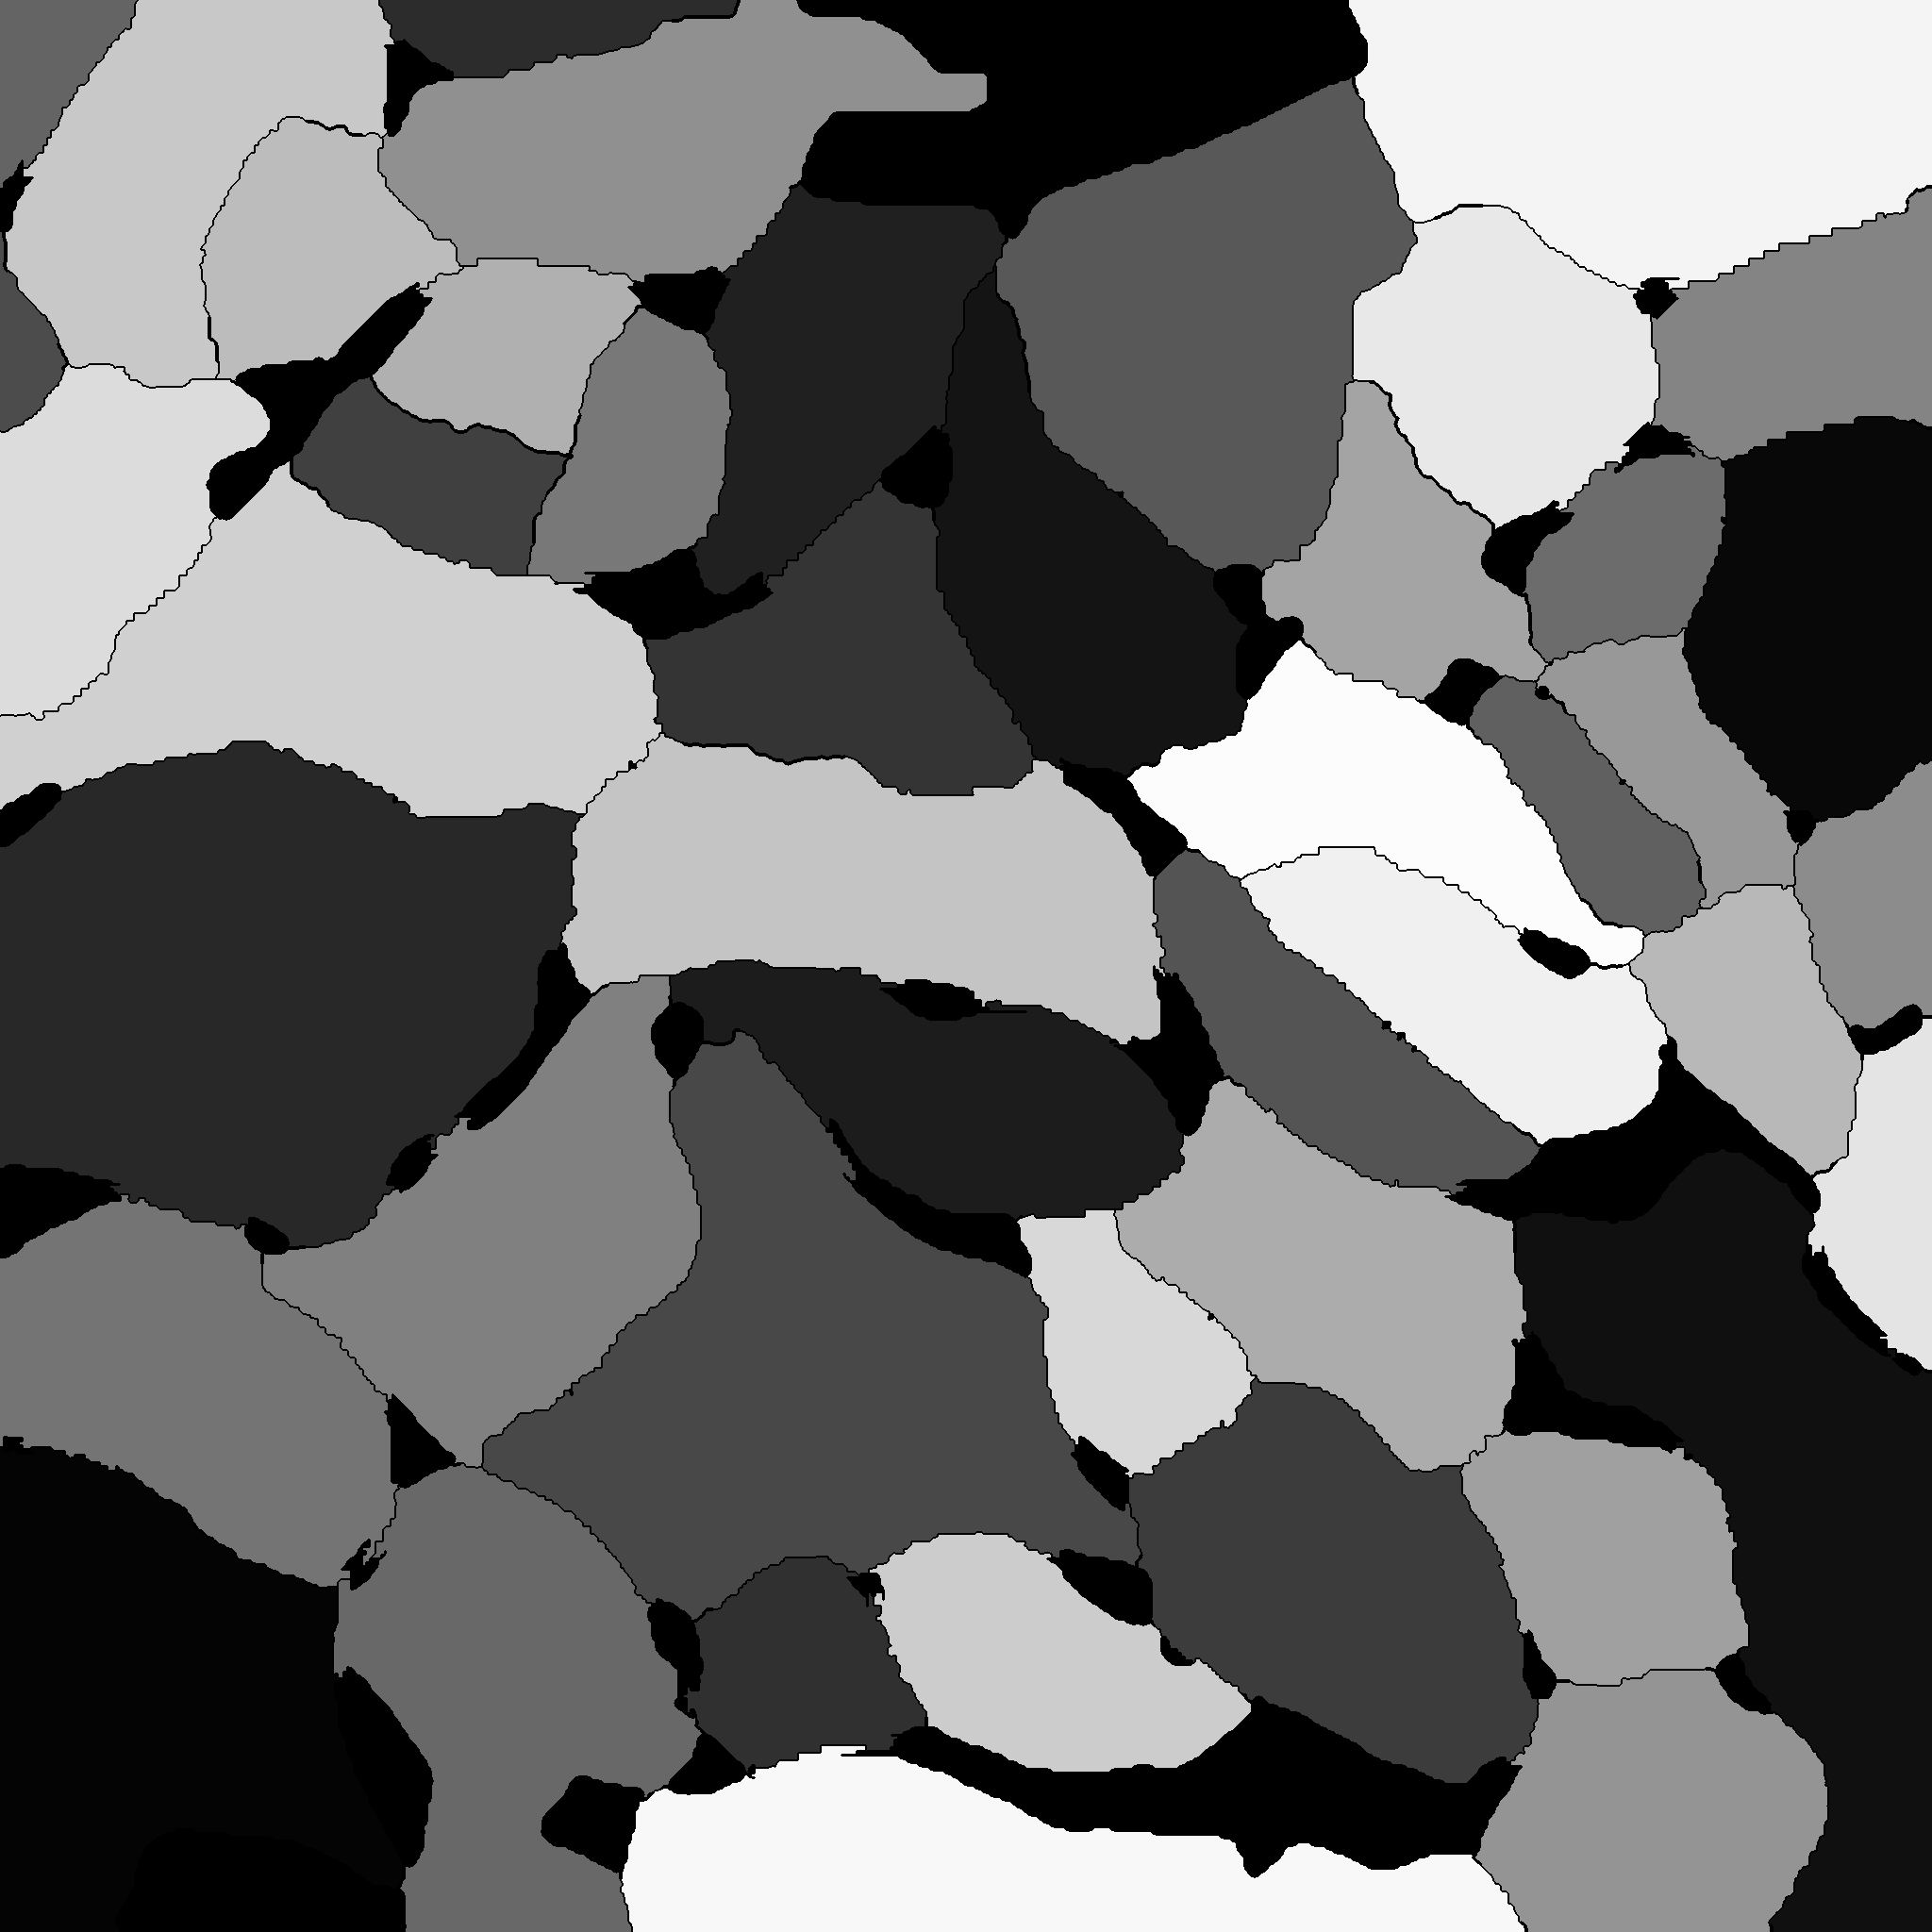

In [6]:
# Show segmentations a bit clearer
Image.fromarray(im_array*100)

The task in this notebook is to build a PyTorch CNN to take input from the above visualized segmentation mask. This will include building a dataset loader, building a backbone and inputting a subsection from train.csv.

## Image Subset

First let's choose some images to train on. I am going to only choose images which have a single label. Then balance between all the labels as much as possible.

In [7]:
# Single Labels
print('Total length of dataframe: '+str(len(df)))
one_label = df[df.Label.str.contains('|', regex=False)==False]
one_label

Total length of dataframe: 21806


,ID,Label
5,5e22a522-bb99-11e8-b2b9-ac1f6b6435d0,0
6,5f79a114-bb99-11e8-b2b9-ac1f6b6435d0,14
9,5c801c04-bb99-11e8-b2b9-ac1f6b6435d0,14
10,5e9afd56-bb99-11e8-b2b9-ac1f6b6435d0,0
11,5f1af6b4-bb99-11e8-b2b9-ac1f6b6435d0,3
...,...,...
21798,d9d99186-bbca-11e8-b2bc-ac1f6b6435d0,3
21799,daa22470-bbca-11e8-b2bc-ac1f6b6435d0,0
21800,dc261180-bbca-11e8-b2bc-ac1f6b6435d0,6
21801,dd0989c4-bbca-11e8-b2bc-ac1f6b6435d0,14


[Text(0.5, 1.0, 'Occurence of Labels')]

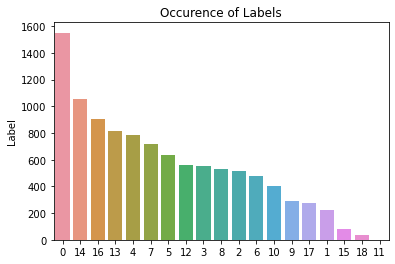

In [6]:
# Investigate occurences of labels
import seaborn as sns
sns.barplot(x=one_label.Label.value_counts().index,
            y = one_label.Label.value_counts()).set(title='Occurence of Labels')

Since this is a test run, I am going to change the problem.

**New problem:**

Multi classification between labels 0, 14 and 16. We will account for the other labels when a proper plan is formed for accounting for weakly labelled data. This notebook is really a learning excersise in using the masks / implementing a custom dataset loader in PyTorch.

<AxesSubplot:title={'center':'Occurence of Labels'}>

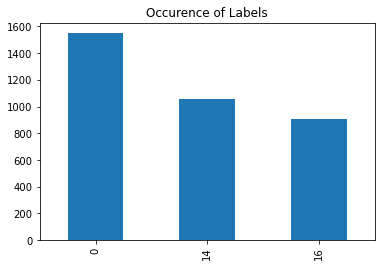

In [8]:
targets =['0', '14', '16']
X = one_label[one_label.Label.isin(targets)]
X.Label.value_counts().plot(kind='bar', title='Occurence of Labels')

Important to note that even though there are few images. Each image may have upwards of 20 segmentations in each image and each image has 4 channels so 1000 images will now be 4000 of image storage :/ .

## PyTorch Dataflow

Tasks:
- Build the dataset
- Build model
- Train
- Evaluate


The model in the example has an input_shape of (224,224,3) so using the merged image taking into account the yellow channel by using:
***
Convert a 4 channel (RGBY) image to a 3 channel RGB image.
    
    Advice From Competition Host/User: lnhtrang

    For annotation (by experts) and for the model, I guess we agree that individual 
    channels with full range px values are better. 
    In annotation, we toggled the channels. 
    For visualization purpose only, you can try blending the channels. 
    For example, 
        - red = red + yellow
        - green = green + yellow/2
        - blue=blue.
        
    Args:
        arr (numpy array): The RGBY, 4 channel numpy array for a given image
    
    Returns:
        RGB Image
***
Building the dataset:
- Make image-subset of training data
- Segment and store masks of those images
- Helper functions for loading and converting images
- Deal with channels, RGBY?
- Pytorch Dataset loader class

### Image Subset

For the Image Subset we want all the images in our dataframe (X) copied into a new folder called image_subset then masked.

The directory should look like:

- image_subset/
    - images/
    - merged_images/
    - masks/
    - subset_train.csv
    
Where the subset_train.csv columns:
ID|Labels

Which we will one hot encode afterwards.

Seems easy let's do it.

In [11]:
class image_subset(object):
    
    def __init__(self, root: str, dst: str):
        self.root = root
        self.dst = dst

        
    def make_csv(self, df):
        df.to_csv(self.dst+'subset_train.csv', index=False)
        print('Made new CSV')
 

    def copy_images(self, id_s: list[str]):
        import glob
        import shutil
        
        def copy(src: str, dst: str):
            # Shutil Copy
            shutil.copyfile(src, dst)     
   

        print('Copying files from '+self.root+' to '+self.dst)
        
        for id_ in id_s:
            #get image id + color
            channels = ['_red.png', '_green.png', '_blue.png', '_yellow.png']
            # copy channel to other folder
            for c in channels:
                # copy each channel over
                copy(self.root+'train/'+id_+c, self.dst+'raw/'+id_+c)
                
        print('Copied files!')

In [12]:
# Create a new directory with the correct training data
import os
# Define root dir

DIR_ROOT = '../input/'
DIR_DST = '../input/image_subset/'

image_subset = image_subset(root = DIR_ROOT, dst = DIR_DST)
image_subset.make_csv(X)
image_subset.copy_images(X.ID)

Made new CSV


In [9]:
print('Length of dataset:')
print(len(X)*4)

import glob
length_dir = glob.glob('../input/image_subset/raw/*.png')
print('Length of directory:')
print(len(length_dir))

Length of dataset:
14044
Length of directory:
14044


As you can see we have succesfully copied over the relevant files. Now we need to segment all 14044 of these files. Place them in the masks folder with their relevant ID's. Then we can merge them.

### Segmenting
We already covered segmenting in the previous notebook. We are only using the cell masks. I will also include the timings for running this, we can extrapolate for the whole dataset later.

In [9]:
import torch


True

In [10]:
!nvidia-smi -L

GPU 0: GeForce GTX 970 (UUID: GPU-fa9c9266-bf91-80d3-02fb-e1c62bb66c85)


In [11]:
# Segment class

class segment(object):
    
    def __init__(self, working_dir: str, output_dir: str):
        self.working_dir = working_dir
        self.output_dir = output_dir

        
    def load_channels(self, id_s: list()):
        import glob
        # load channels, sort them to make sure they align
        red_images = sorted([self.working_dir+'raw/'+l+'_red.png' for l in id_])
        green_images = sorted([self.working_dir+'raw/'+l+'_green.png' for l in id_])
        blue_images = sorted([self.working_dir+'raw/'+l+'_blue.png' for l in id_])
        yellow_images = sorted([self.working_dir+'raw/'+l+'_yellow.png' for l in id_])
                              
        print(len(red_images), len(green_images), len(blue_images), len(yellow_images))
        
        # Split into bio names -> list
        mt = red_images # microtubules
        er = yellow_images # endoplasmic reticulum
        nu = blue_images # nucleus 
        pr = green_images # [proteins]
        images = [mt, er, nu]
        
        return(images)
    
    
    def mask(self, images: list()):
        # Segment image and save to dir 
        # HPA tool
        import os
        import imageio
        import hpacellseg.cellsegmentator as cellsegmentator
        from hpacellseg.utils import label_cell, label_nuclei
        
        NUC_MODEL = "./nuclei-model.pth"
        CELL_MODEL = "./cell-model.pth"

        segmentator = cellsegmentator.CellSegmentator(
            NUC_MODEL,
            CELL_MODEL,
            scale_factor=0.25,
            device="cuda",
            padding=False,
            multi_channel_model=True,
        )

        # For nuclei
        nuc_segmentations = segmentator.pred_nuclei(images[2])

        # For full cells
        cell_segmentations = segmentator.pred_cells(images)

        # post-processing
        for i, pred in enumerate(cell_segmentations):
            print((i / len(cell_segmentations))*100)
            nuclei_mask, cell_mask = label_cell(nuc_segmentations[i], cell_segmentations[i])
            FOVname = os.path.basename(images[0][i]).replace('red','predictedmask')
            imageio.imwrite(self.output_dir+ FOVname, cell_mask) 
        


In [ ]:
# Use segment class
WORKING_DIR = '../input/image_subset/'
OUTPUT_DIR = '../input/image_subset/mask/'

# initiate mask
seg = segment(WORKING_DIR, OUTPUT_DIR)

for id_ in np.array_split(X.ID.values, 100):
    # load channels
    images = seg.load_channels(id_s=id_)
    import time
    t1 = time.time()
    # mask images
    seg.mask(images)
    t2 = time.time()
    print('Segmenting images took: '+str(t2-t1)+' s')

36 36 36 36
please compile abn


C:\Users\Admin\miniconda3\envs\cell\lib\site-packages\torch\serialization.py:656: SourceChangeWarning: source code of class 'pytorch_zoo.unet.DPNUnet' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
C:\Users\Admin\miniconda3\envs\cell\lib\site-packages\torch\serialization.py:656: SourceChangeWarning: source code of class 'torch.nn.modules.container.ModuleList' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
C:\Users\Admin\miniconda3\envs\cell\lib\site-packages\torch\serialization.py:656: SourceChangeWarning: source code of class 'torch.nn.modules.container.Sequential' has changed. you can retrieve the original source code by a

0.0
2.7777777777777777
5.555555555555555
8.333333333333332
11.11111111111111
13.88888888888889
16.666666666666664
19.444444444444446
22.22222222222222
25.0
27.77777777777778
30.555555555555557
33.33333333333333
36.11111111111111
38.88888888888889
41.66666666666667
44.44444444444444
47.22222222222222
50.0
52.77777777777778
55.55555555555556
58.333333333333336
61.111111111111114
63.888888888888886
66.66666666666666
69.44444444444444
72.22222222222221
75.0
77.77777777777779
80.55555555555556
83.33333333333334
86.11111111111111
88.88888888888889
91.66666666666666
94.44444444444444
97.22222222222221
Segmenting images took: 276.32865715026855 s
36 36 36 36
0.0
2.7777777777777777
5.555555555555555
8.333333333333332
11.11111111111111
13.88888888888889
16.666666666666664
19.444444444444446
22.22222222222222
25.0
27.77777777777778
30.555555555555557
33.33333333333333
36.11111111111111
38.88888888888889
41.66666666666667
44.44444444444444
47.22222222222222
50.0
52.77777777777778
55.55555555555556

Okay now our problem is we are matching the masks to our 4 channels. We should merge each 4 channel images to one image which has all 4 channels in one. We should also re scale the images using a transformer before placing into the model.

In [ ]:
# Conver to rgby

def convert_rgby_to_rgb(arr):
    """ Convert a 4 channel (RGBY) image to a 3 channel RGB image.
    
    Advice From Competition Host/User: lnhtrang

    For annotation (by experts) and for the model, I guess we agree that individual 
    channels with full range px values are better. 
    In annotation, we toggled the channels. 
    For visualization purpose only, you can try blending the channels. 
    For example, 
        - red = red + yellow
        - green = green + yellow/2
        - blue=blue.
        
    Args:
        arr (numpy array): The RGBY, 4 channel numpy array for a given image
    
    Returns:
        RGB Image
    """
    
    rgb_arr = np.zeros_like(arr[..., :-1])
    rgb_arr[..., 0] = arr[..., 0]
    rgb_arr[..., 1] = arr[..., 1]+arr[..., 3]/2
    rgb_arr[..., 2] = arr[..., 2]
    
    return rgb_arr

In [ ]:
id_s = X.ID
ROOT_DIR = '../input/image_subset/'
SAVE_DIR = '../input/image_subset/image/'
def get_image_array(path):
    # return np array of image path
    return(np.array(Image.open(path)))

for i_d in id_s:
    r = get_image_array('../input/image_subset/raw/'+i_d+'_red.png')
    g = get_image_array('../input/image_subset/raw/'+i_d+'_green.png')
    b = get_image_array('../input/image_subset/raw/'+i_d+'_blue.png')
    y = get_image_array('../input/image_subset/raw/'+i_d+'_yellow.png')
    
    arr = np.dstack((r,g,b,y))
    Image.fromarray(convert_rgby_to_rgb(arr)).save(SAVE_DIR+i_d+'.png')

Great now we have a new directory of RGBY converted RGB images. This will be our new directory for our dataset. Let's view a couple of them to show what I mean.

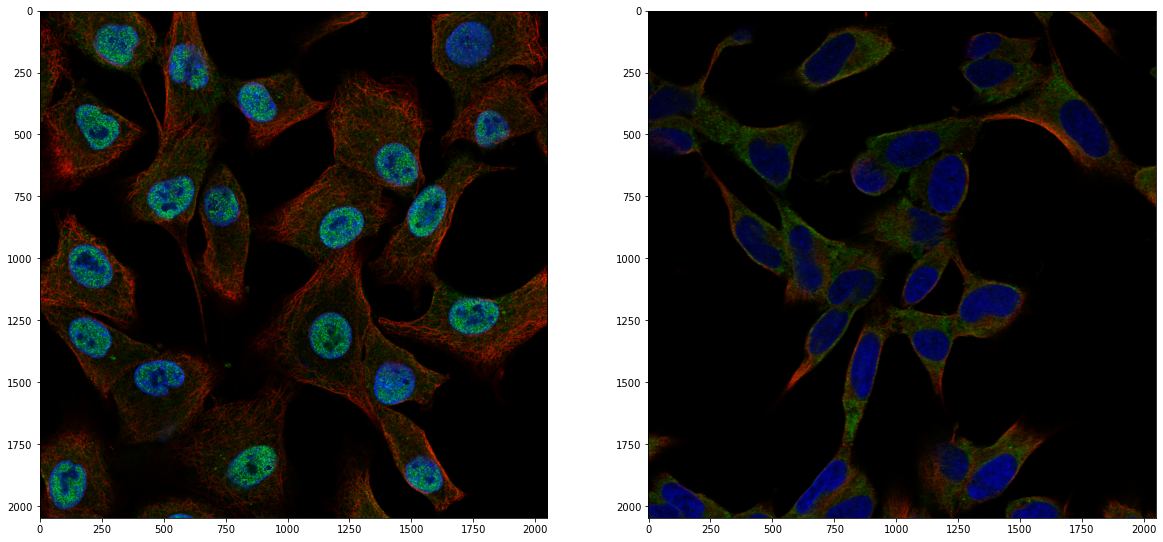

In [10]:
# view a couple RGBY-RGB converted images
import random
import matplotlib.pyplot as plt
SAVE_DIR = '../input/image_subset/image/'
rand = random.sample(sorted(X.ID), 2)
fig, ax = plt.subplots(1,2, figsize=(20,50))
ax[0].imshow(Image.open(SAVE_DIR+rand[0]+'.png'))
ax[1].imshow(Image.open(SAVE_DIR+rand[1]+'.png'))
plt.show()